Analyzing encrypted file: /Users/bodapati/Documents/encrypted_data.csv

=== Pattern Analysis ===
Total blocks: 372801
Unique blocks: 372801
Repeated blocks: 0
No repeated blocks detected.


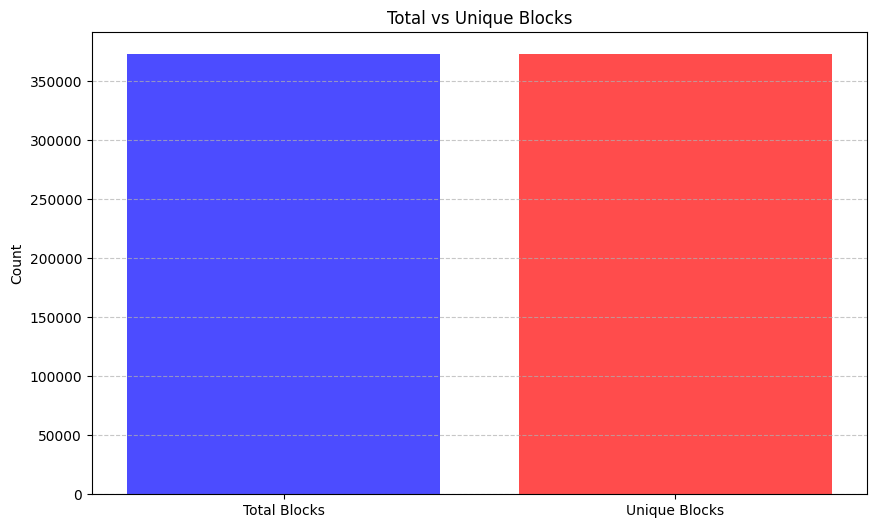


=== Length Leakage Check ===
Ciphertext length: 5964816
Ciphertext length aligns with block size.


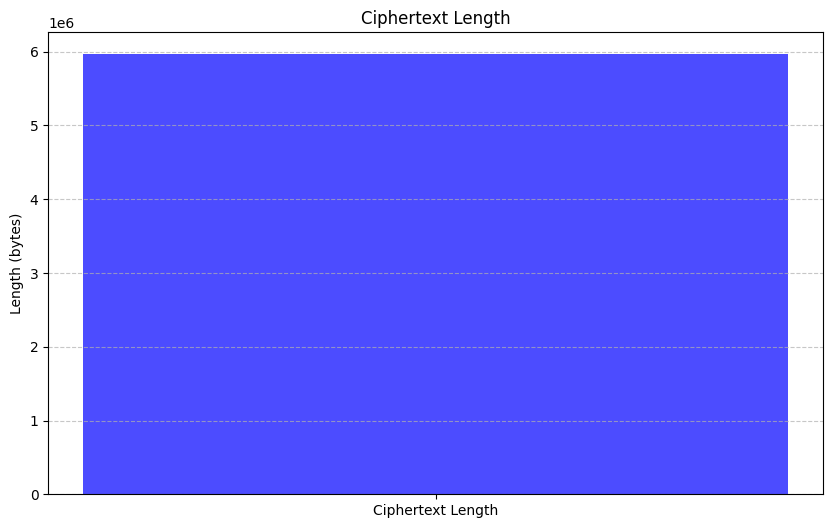


=== Entropy Test ===
Shannon Entropy: 8.0000 (Max: 8.0000)
Ciphertext appears random.


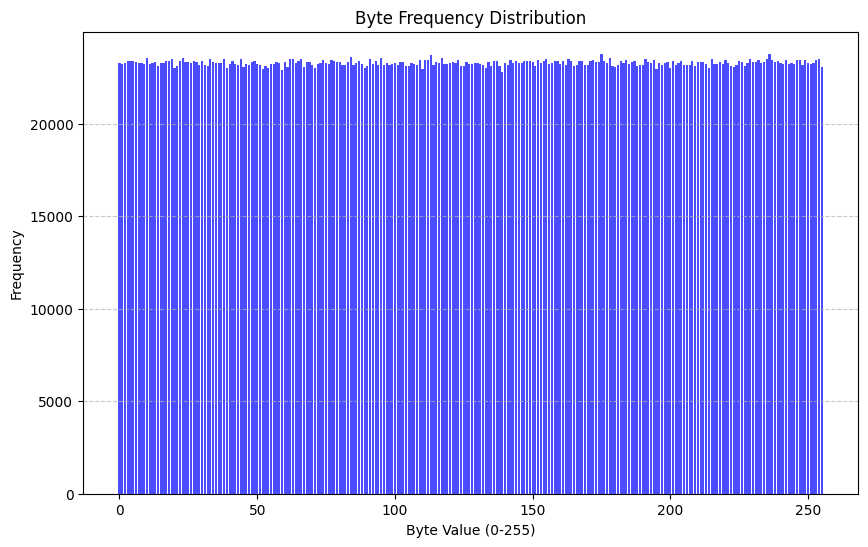


=== Chi-Square Test ===
Chi-Square Statistic: 230.8733, p-value: 0.8586
Ciphertext byte distribution appears uniform.


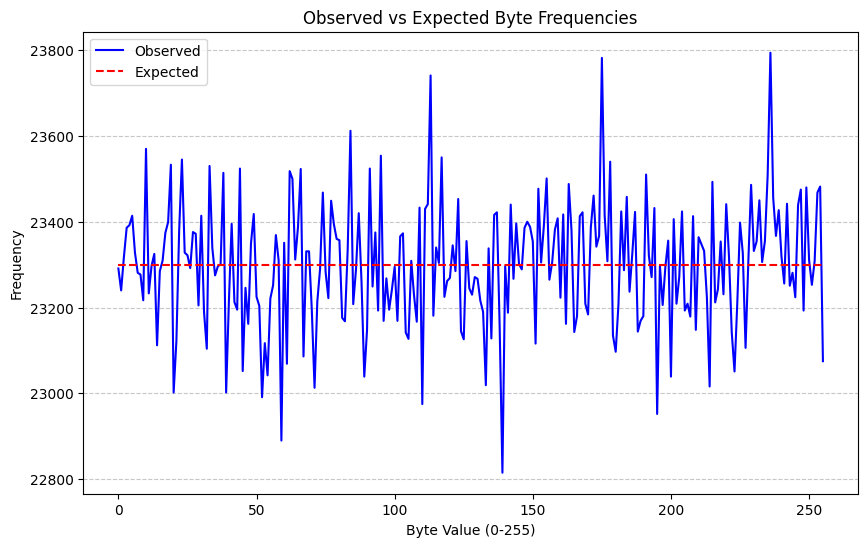

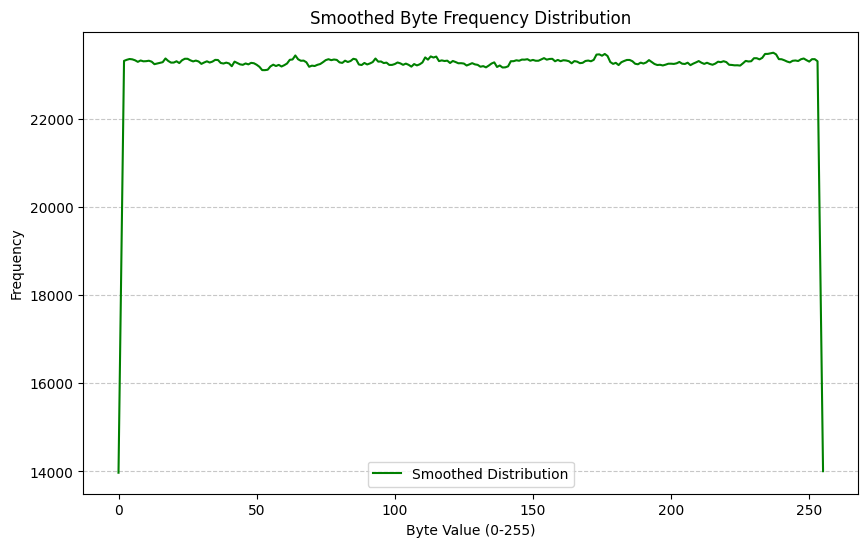


=== Chosen Ciphertext Attack (CCA) ===
Original ciphertext length: 5964816 bytes
Recovered plaintext of last block via CCA:  b,"ݛOJ


In [5]:
import os
import math
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import padding

# Helper function to pad data (PKCS7 padding)
def pad(data):
    padder = padding.PKCS7(128).padder()
    padded_data = padder.update(data) + padder.finalize()
    return padded_data

# Helper function to unpad data (PKCS7 unpadding)
def unpad(data):
    unpadder = padding.PKCS7(128).unpadder()
    unpadded_data = unpadder.update(data) + unpadder.finalize()
    return unpadded_data

# Decryption oracle with padding oracle vulnerability
class VulnerableDecryptionOracle:
    def __init__(self, key, iv):
        self.key = key
        self.iv = iv

    def decrypt(self, ciphertext):
        cipher = Cipher(algorithms.AES(self.key), modes.CBC(self.iv), backend=default_backend())
        decryptor = cipher.decryptor()
        plaintext_padded = decryptor.update(ciphertext) + decryptor.finalize()
        return unpad(plaintext_padded)

    def is_padding_valid(self, ciphertext):
        """Simulates a padding oracle that leaks whether padding is valid."""
        try:
            self.decrypt(ciphertext)
            return True
        except ValueError:  # Invalid padding
            return False

# Function to perform a padding oracle attack (CCA)
def padding_oracle_attack(ciphertext, oracle, block_size=16):
    """
    Simulates a padding oracle attack to recover the plaintext of the last block.
    """
    ciphertext_length = len(ciphertext)
    num_blocks = ciphertext_length // block_size
    if num_blocks < 2:
        print("Error: Ciphertext must have at least 2 blocks for padding oracle attack.")
        return None

    # Target the last block (C_n) and modify the second-to-last block (C_{n-1})
    target_block_idx = num_blocks - 1
    prev_block_idx = target_block_idx - 1

    # Extract the blocks
    blocks = [ciphertext[i:i + block_size] for i in range(0, ciphertext_length, block_size)]
    prev_block = blocks[prev_block_idx]
    target_block = blocks[target_block_idx]

    # Initialize the recovered plaintext for the target block
    plaintext_bytes = bytearray(block_size)
    intermediate_bytes = bytearray(block_size)  # Intermediate state (decrypted but XORed with prev_block)

    # Work backwards from the last byte to the first byte in the block
    for byte_idx in range(block_size - 1, -1, -1):
        padding_value = block_size - byte_idx  # PKCS7 padding value for this position
        modified_prev_block = bytearray(prev_block)

        # Set up the padding for the bytes we've already recovered
        for i in range(byte_idx + 1, block_size):
            modified_prev_block[i] = intermediate_bytes[i] ^ padding_value

        # Try all possible values for the current byte
        for guess in range(256):
            modified_prev_block[byte_idx] = guess
            modified_ciphertext = b''.join(blocks[:prev_block_idx] + [bytes(modified_prev_block)] + blocks[target_block_idx:])

            if oracle.is_padding_valid(modified_ciphertext):
                # Found the correct guess
                intermediate_bytes[byte_idx] = guess ^ padding_value
                plaintext_bytes[byte_idx] = intermediate_bytes[byte_idx] ^ prev_block[byte_idx]
                break

    return bytes(plaintext_bytes)

# Function to perform all checks and CCA
def perform_cca_checks(encrypted_file_path):
    if not os.path.exists(encrypted_file_path):
        print(f"Error: File not found at {encrypted_file_path}")
        return

    # Read the encrypted data
    with open(encrypted_file_path, 'rb') as f:
        ciphertext = f.read()

    print(f"Analyzing encrypted file: {encrypted_file_path}\n")
    # Perform existing statistical analysis (from your original code)
    analyze_patterns(ciphertext)
    check_length_leakage(ciphertext)
    test_entropy(ciphertext)
    chi_square_test(ciphertext)
    plot_smoothed_distribution(ciphertext)

    # Simulate a CCA with a vulnerable oracle
    key = os.urandom(16)  # Example key (in practice, this would be secret)
    iv = os.urandom(16)   # Example IV (in practice, this would be secret)
    oracle = VulnerableDecryptionOracle(key, iv)

    print(f"\n=== Chosen Ciphertext Attack (CCA) ===")
    print(f"Original ciphertext length: {len(ciphertext)} bytes")

    # Perform padding oracle attack to recover the last block
    recovered_last_block = padding_oracle_attack(ciphertext, oracle)
    if recovered_last_block:
        print(f"Recovered plaintext of last block via CCA: {recovered_last_block.decode('utf-8', errors='ignore')}")
    else:
        print("CCA failed to recover plaintext.")

# Your existing statistical analysis functions (unchanged)
def analyze_patterns(ciphertext):
    block_size = 16
    blocks = [ciphertext[i:i + block_size] for i in range(0, len(ciphertext), block_size)]
    unique_blocks = set(blocks)
    repetition_count = len(blocks) - len(unique_blocks)

    print(f"=== Pattern Analysis ===")
    print(f"Total blocks: {len(blocks)}")
    print(f"Unique blocks: {len(unique_blocks)}")
    print(f"Repeated blocks: {repetition_count}")

    if repetition_count > 0:
        print("Pattern detected: Repeated blocks found!")
    else:
        print("No repeated blocks detected.")

    plt.figure(figsize=(10, 6))
    plt.bar(['Total Blocks', 'Unique Blocks'], [len(blocks), len(unique_blocks)], color=['blue', 'red'], alpha=0.7)
    plt.title("Total vs Unique Blocks")
    plt.ylabel("Count")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

def check_length_leakage(ciphertext, block_size=16):
    ciphertext_length = len(ciphertext)
    print(f"\n=== Length Leakage Check ===")
    print(f"Ciphertext length: {ciphertext_length}")
    if ciphertext_length % block_size != 0:
        print("Warning: Ciphertext length is not a multiple of block size!")
    else:
        print("Ciphertext length aligns with block size.")
    
    plt.figure(figsize=(10, 6))
    plt.bar(['Ciphertext Length'], [ciphertext_length], color="blue", alpha=0.7)
    plt.title("Ciphertext Length")
    plt.ylabel("Length (bytes)")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

def calculate_entropy(data):
    counter = Counter(data)
    total_length = len(data)
    entropy = -sum((count / total_length) * math.log2(count / total_length) for count in counter.values())
    return entropy

def test_entropy(ciphertext):
    entropy = calculate_entropy(ciphertext)
    print(f"\n=== Entropy Test ===")
    print(f"Shannon Entropy: {entropy:.4f} (Max: {math.log2(256):.4f})")

    if entropy < 7.8:
        print("Warning: Ciphertext may not be sufficiently random!")
    else:
        print("Ciphertext appears random.")

    byte_counts = Counter(ciphertext)
    byte_values = list(range(256))
    frequencies = [byte_counts[byte] for byte in byte_values]

    plt.figure(figsize=(10, 6))
    plt.bar(byte_values, frequencies, color="blue", alpha=0.7)
    plt.title("Byte Frequency Distribution")
    plt.xlabel("Byte Value (0-255)")
    plt.ylabel("Frequency")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

def chi_square_test(ciphertext):
    byte_counts = [0] * 256
    for byte in ciphertext:
        byte_counts[byte] += 1

    expected = [len(ciphertext) / 256] * 256
    chi2, p = chisquare(byte_counts, expected)
    print(f"\n=== Chi-Square Test ===")
    print(f"Chi-Square Statistic: {chi2:.4f}, p-value: {p:.4f}")

    if p < 0.05:
        print("Warning: Ciphertext byte distribution is not uniform!")
    else:
        print("Ciphertext byte distribution appears uniform.")

    plt.figure(figsize=(10, 6))
    plt.plot(byte_counts, label="Observed", color="blue")
    plt.plot(expected, label="Expected", color="red", linestyle="--")
    plt.title("Observed vs Expected Byte Frequencies")
    plt.xlabel("Byte Value (0-255)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

def plot_smoothed_distribution(ciphertext):
    byte_counts = Counter(ciphertext)
    byte_values = np.array(list(range(256)))
    frequencies = np.array([byte_counts[byte] for byte in byte_values])

    smoothed_frequencies = np.convolve(frequencies, np.ones(5)/5, mode="same")

    plt.figure(figsize=(10, 6))
    plt.plot(byte_values, smoothed_frequencies, color="green", label="Smoothed Distribution")
    plt.title("Smoothed Byte Frequency Distribution")
    plt.xlabel("Byte Value (0-255)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

if __name__ == "__main__":
    encrypted_file_path = "/Users/bodapati/Documents/encrypted_data.csv"
    perform_cca_checks(encrypted_file_path)